# Lab: Trajectory Analysis and Convergence Evaluation

## What is Trajectory Analysis?

When evaluating AI agents, we typically focus on **output quality** - is the answer correct, clear, and helpful? But there's another critical dimension: **the path the agent took to get there**.

**Trajectory** refers to the sequence of steps (router decisions, tool calls, LLM invocations) that an agent executes to produce its final output.

## Why Trajectory Matters

### The Efficiency Problem

![Does trajectory matter?](pic/does_trajectory_matters.png)

Even when your agent produces the correct output, **efficiency matters**. Consider these two execution paths:

**Inefficient Path (left)**: 11 steps
1. User input
2. Router
3. Database Lookup Tool
4. Router
5. Data Analyzer
6. Router
7. Database Lookup Tool (redundant!)
8. Router
9. Data Analyzer (redundant!)
10. Router
11. Output

**Efficient Path (right)**: 6 steps
1. User input
2. Router
3. Database Lookup Tool
4. Data Analyzer
5. Router
6. Output

Both paths produce the same correct answer, but the inefficient path:
- **Costs 83% more** in LLM API calls (11 steps vs 6)
- **Takes significantly longer** to complete
- **Wastes computational resources** with redundant tool calls
- **Provides worse user experience** due to increased latency

### Real-World Complexity

![Trajectory complexity](pic/trajectory_analysis_using_arize_phoenix.png)

As AI systems grow in sophistication, trajectory complexity explodes:

- **Single agent systems**: One router coordinating 3+ tools, each with multiple internal steps
- **Multi-agent systems**: Multiple agents that can delegate to each other, creating deeply branching execution trees
- **Tool chains**: Tools calling other tools, creating nested execution paths that are hard to debug

**This is where Arize Phoenix becomes essential** - it provides visibility into these complex trajectories, allowing you to:
- Identify bottlenecks and inefficiencies
- Compare execution paths across different queries
- Detect when the agent "gets lost" in loops
- Optimize routing and tool selection logic

## Convergence: Measuring Path Optimality

![Convergence metric](pic/trajectory_analysis_convergence.png)

**Convergence** is a quantitative metric that answers: *"How closely does my agent follow the optimal path?"*

### How Convergence Works

1. **Create semantically equivalent test cases**: Multiple phrasings of the same query
   - "What was the average quantity sold per transaction?"
   - "What is the mean number of items per sale?"
   - "Calculate the typical quantity per transaction"

2. **Run each test case** through your agent and track the path length (number of steps)

3. **Identify the optimal path**: The shortest successful path is considered optimal

4. **Calculate convergence score** for each execution:
   ```
   convergence_score = optimal_path_length / actual_path_length
   ```

### Interpreting Convergence Scores

- **1.0** = Perfect convergence (agent took the optimal path)
- **0.75** = Agent took 33% more steps than optimal
- **0.5** = Agent took twice as many steps as optimal
- **0.33** = Agent took three times as many steps as optimal (significant inefficiency)

### What This Lab Demonstrates

In this notebook, you will:

1. **Create a dataset** of 17 semantically equivalent questions about sales data
2. **Run the agent** on each question using Phoenix Experiments framework
3. **Track path lengths** for each execution
4. **Compute convergence scores** comparing actual paths to the optimal path
5. **Visualize results** in Phoenix UI to identify improvement opportunities

### Key Insight

Low convergence scores indicate:
- **Router confusion**: The LLM router isn't consistently identifying the right tool
- **Poor tool descriptions**: Tools aren't clearly differentiated in their schemas
- **Prompt engineering issues**: System prompts may be causing unnecessary tool loops
- **Missing optimizations**: You might benefit from caching, few-shot examples, or routing refinements

High convergence scores (close to 1.0) indicate an efficient, well-optimized agent that consistently finds the shortest path to correct answers.

---

## Importing necessary libraries 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from phoenix.client import Client

# Import utilities
from utils import run_agent, get_phoenix_endpoint
from phoenix.experiments import run_experiment, evaluate_experiment
from phoenix.experiments.types import Example
from phoenix.experiments.evaluators import create_evaluator
import pandas as pd
from datetime import datetime
import nest_asyncio

nest_asyncio.apply()

<p style="background-color:#grey; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results might differ from those shown in the video.</p>

In [ ]:
# Start the Phoenix server
import phoenix as px
from phoenix.session.session import launch_app

# start the phoenix instance
# 12.x phoenix version runs this way
session = launch_app()

# Create Phoenix client for dataset operations (Phoenix 12.x)
phoenix_client = Client()

## Creating the Dataset of Test Cases

In [ ]:
# dataset questions we want to upload to phoenix to run our trajectory analysis over them
convergence_questions = [
    "What was the average quantity sold per transaction?",
    "What is the mean number of items per sale?", 
    "Calculate the typical quantity per transaction",
    "What's the mean transaction size in terms of quantity?",
    "On average, how many items were purchased per transaction?",
    "What is the average basket size per sale?",
    "Calculate the mean number of products per purchase",
    "What's the typical number of units per order?",
    "What is the average number of products bought per purchase?",
    "Tell me the mean quantity of items in a typical transaction",
    "How many items does a customer buy on average per transaction?",
    "What's the usual number of units in each sale?",
    "What is the typical amount of products per transaction?",
    "Show the mean number of items customers purchase per visit",
    "What's the average quantity of units per shopping trip?",
    "How many products do customers typically buy in one transaction?",
    "What is the standard basket size in terms of quantity?"
]

# compress into panda dataframe
convergence_df = pd.DataFrame({
    'question': convergence_questions
})

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Phoenix 12.x: Upload dataset to Phoenix using the correct API
# In previous versions they use "upload_dataset()"
dataset = phoenix_client.datasets.create_dataset(
    name=f"convergence_questions-{now}",
    dataframe=convergence_df,
    input_keys=["question"]
)

print(f"Created and uploaded dataset '{dataset.name}' with {len(convergence_questions)} examples to Phoenix")

You can open this link to check out the Phoenix UI and the uploaded dataset. You can use the same link to check out the results of the experiment you'll run in this notebook. 

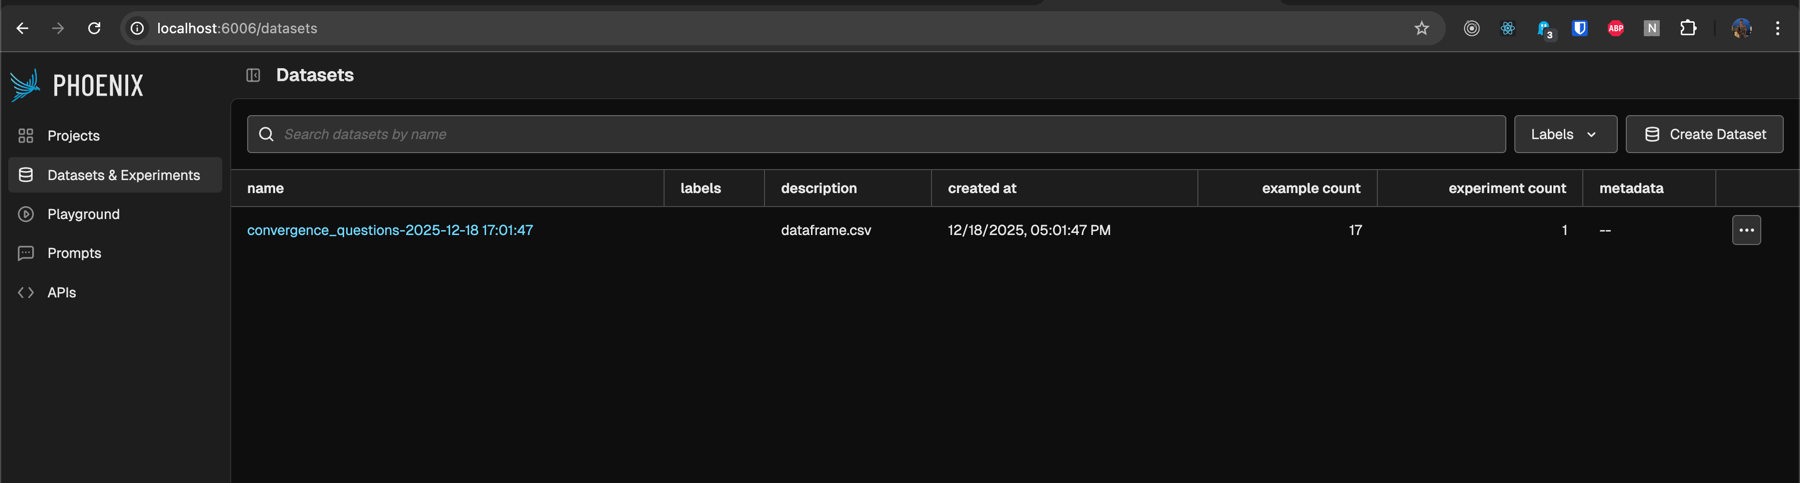

**Note**: 
- Since each notebook of this course runs in an isolated environment, each notebook links to a different Phoenix server. This is why you won't see the projects you've worked on in the previous notebooks. 
- Make sure that the notebook's kernel is running when checking the Phoenix UI. If the link does not open, it might be because the notebook has been open or inactive for a long time. In that case, make sure to refresh the browser, run all previous cells and then check this link. 

In [ ]:
print(get_phoenix_endpoint())

## Creating the Task

In [ ]:
# helper method to format the output returned by the task
def format_message_steps(messages):
    """
    Convert a list of message objects into a readable format that shows the steps taken.

    Args:
        messages (list): A list of message objects containing role, content, tool calls, etc.

    Returns:
        str: A readable string showing the steps taken.
    """
    steps = []
    for message in messages:
        role = message.get("role")
        if role == "user":
            steps.append(f"User: {message.get('content')}")
        elif role == "system":
            steps.append("System: Provided context")
        elif role == "assistant":
            if message.get("tool_calls"):
                for tool_call in message["tool_calls"]:
                    tool_name = tool_call["function"]["name"]
                    steps.append(f"Assistant: Called tool '{tool_name}'")
            else:
                steps.append(f"Assistant: {message.get('content')}")
        elif role == "tool":
            steps.append(f"Tool response: {message.get('content')}")
    
    return "\n".join(steps)

In [ ]:
def run_agent_and_track_path(example: Example) -> str:
    messages = [{"role": "user", "content": example.input.get("question")}]
    ret = run_agent(messages)
    return {"path_length": len(ret), "messages": format_message_steps(ret)}

## Running the Experiment

Examples of executed code:
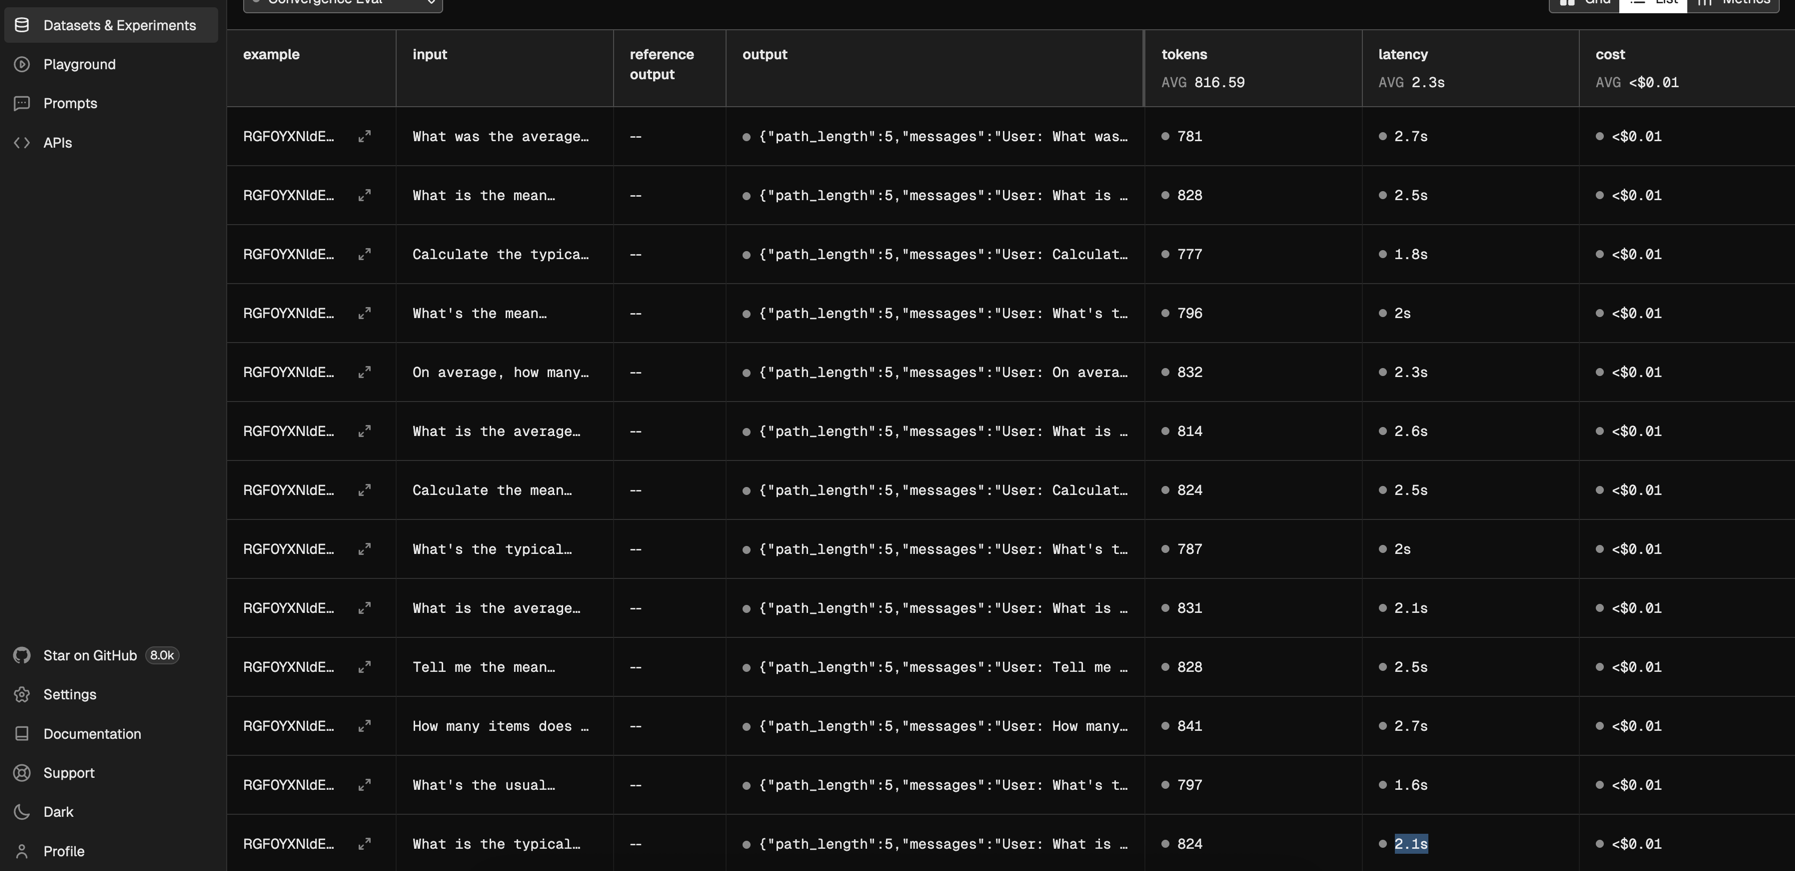


In [ ]:
experiment = run_experiment(dataset,
                            run_agent_and_track_path,
                            experiment_name="Convergence Eval",
                            experiment_description="Evaluating the convergence of the agent")

In [ ]:
experiment.as_dataframe()

## Evaluating the Path

In [ ]:
outputs = experiment.as_dataframe()["output"].to_dict().values()

# Will include the user and system messages
optimal_path_length = min(output.get('path_length') for output in outputs if output and output.get('path_length') is not None)
print(f"The optimal path length is {optimal_path_length}")

In [ ]:
@create_evaluator(name="Convergence Eval", kind="CODE")
def evaluate_path_length(output: str) -> float:
    if output and output.get("path_length"):
        return optimal_path_length/float(output.get("path_length"))
    else:
        return 0

In [ ]:
experiment = evaluate_experiment(experiment,
                            evaluators=[evaluate_path_length])


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (12/18/25 05:05 PM +0200)
--------------------------------------------
          evaluator   n  n_scores  avg_score
0  Convergence Eval  17        17        1.0

Tasks Summary (12/18/25 05:02 PM +0200)
---------------------------------------
   n_examples  n_runs  n_errors
0          17      17         0

<div style="background-color:#grey; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>